# Classification of Response to Neoadjuvant Treatment: Late Fusion of Image and Clinical Data to Improve Accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
#import keras_tuner as kt
#from keras_tuner.engine.hyperparameters import HyperParameters
#import tensorflow_hub as hub
from tensorflow.keras import backend as K
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd
import numpy as np
import collections
from collections import Counter
import random
import datetime
import os

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


pd.set_option('display.max_columns', None)

In [5]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]


# Building Neural Network

## Load both pre-made npy. file for the images and cleaned clinical dataframe
### Concatanate image and clinical data and split into validation and training sets to ensure matching indexes for fusion

In [7]:
image_dataset = np.load("Datasets\Breast_dataset_neoadjuvant-2D-256- with identifier.npy", allow_pickle=True)
clinical_dataset = pd.read_csv("Datasets\Neoadjuvant_clean_clinical.csv")
clinical_dataset = clinical_dataset.drop("Unnamed: 0", axis = 1)

In [ ]:
# version for google drive 
image_dataset = np.load("/content/drive/MyDrive/Datasets/Breast_dataset_neoadjuvant-2D-256- with identifier.npy", allow_pickle=True)
clinical_dataset = pd.read_csv("/content/drive/MyDrive/Datasets/Neoadjuvant_clean_clinical.csv")
clinical_dataset = clinical_dataset.drop("Unnamed: 0", axis = 1)

In [8]:
print(image_dataset.shape)
print(len(clinical_dataset))
#clinical_dataset.columns

(185, 3)
185


In [9]:
df = pd.DataFrame(image_dataset, columns =["image", "Response", "Patient ID"])
df.head()

,image,Response,Patient ID
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,Breast_MRI_003
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,Breast_MRI_005
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,Breast_MRI_010
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,Breast_MRI_012
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,Breast_MRI_019


In [10]:
# note to self should have left patient IDs the same in original csv file rather than convert to numeric

In [11]:
def file_name_edit(ID):
    ID = int(ID)
    num = str(ID).zfill(3)
    new_string= "Breast_MRI_"+str(num)
    return new_string

clinical_dataset["PatientID"] = clinical_dataset.apply(lambda row: file_name_edit(row["Patient ID"]), axis = 1)
clinical_dataset =clinical_dataset.drop(["Patient ID"], axis = 1)
clinical_dataset= clinical_dataset.rename(columns ={"PatientID" : "Patient ID"})
clinical_dataset.head()

,Staging(Tumor Size),Date of Birth (Days),Staging(Nodes),Tumor Grade Mitotic,Mol Subtype_Luminal A,Lymphadenopathy or Suspicious Nodes,Tumor Grade Tubule,PR,Tumor Grade Nuclear,Response to treatment,Patient ID
0,2,22685,1,1,1,1,3,1,2,1,Breast_MRI_003
1,2,13932,1,3,0,1,3,0,3,1,Breast_MRI_005
2,3,24712,2,2,0,1,3,0,3,1,Breast_MRI_010
3,2,15885,2,3,0,1,3,0,3,0,Breast_MRI_012
4,1,13100,1,1,1,0,3,1,2,0,Breast_MRI_019


In [12]:
#for early dataset versions made without Patient ID indexer
#joint_df = pd.concat([df, clinical_dataset], axis=1)

joint_df = pd.merge(df, clinical_dataset, on = ["Patient ID"] )
print(len(joint_df))

185


### this is just a unit test to make sure that the dataframes aligned correctly 

In [13]:
def match(column1, column2):
    if column1 == column2:
        return 1
    else:
        return 0

joint_df['match'] = joint_df.apply(lambda row: match(row['Response'], row['Response to treatment']), axis=1)
joint_df['match'].value_counts()

1    185
Name: match, dtype: int64

In [14]:
train_df, test_df = train_test_split(joint_df, test_size=0.3, random_state=42)

In [15]:
train_image= train_df['image'].tolist()
test_image=test_df['image'].tolist()

train_label= train_df['Response to treatment'].tolist()
test_label=test_df['Response to treatment'].tolist()

# Image Classification Model
### There are two different versions of this model:
### Method 1: Convolutional neural network 
### Method 2: Transfer learning MobileNet v2

# Train and Validation data

In [78]:
tf.keras.backend.clear_session()

In [79]:
IMG_SIZE = 256
BATCH_SIZE = 4

In [80]:
X_train_image = np.asarray(train_image).astype(np.float32)
y_train_image = np.asarray(train_label).astype(np.float32)
X_test_image = np.asarray(test_image).astype(np.float32)
y_test_image = np.asarray(test_label).astype(np.float32)

In [81]:
X_train_image.shape

(129, 256, 256)

In [82]:
y_train_image.shape

(129,)

In [83]:
train_loader = tf.data.Dataset.from_tensor_slices((X_train_image, y_train_image))
test_loader = tf.data.Dataset.from_tensor_slices((X_test_image, y_test_image))

## Rebalancing Class Weights

In [84]:
#org_size = collections.Counter(y_train) 
#print(org_size)
num0 = np.count_nonzero(y_train_image == np.array(0))
num1 = np.count_nonzero(y_train_image == np.array(1))
org_size = {0 : num0 , 1 : num1}

n_classes= 2 
n_sample0= int(org_size.get(0))
n_sample1= int(org_size.get(1))
n_samples= n_sample0 + n_sample1
    

#Weights for class 0 (no reccurence):
w0=  n_samples/(n_classes*n_sample0) 

#Weights for class 1 (cancer recurence):
w1= n_samples/(n_classes*n_sample1)

class_weights = {0:w0*2, 1: w1*2}
print(org_size)
print(class_weights)

{0: 67, 1: 62}
{0: 1.9253731343283582, 1: 2.0806451612903225}


## Method 1 Covolutional Neural Network

In [85]:
def train_preprocessing(images, labels):
    
    images = tf.expand_dims(images, axis =3)
    images = tf.image.stateless_random_flip_left_right(images ,seed = (2,3))
    images = tf.image.stateless_random_flip_up_down(images, seed = (2,3))
    #images =tf.image.central_crop(images, 0.70)
    #images = tf.image.resize(images,[256,256])
    images = tf.cast(images, tf.float32) /255.
    
    return (images, labels)


def validation_preprocessing(images, labels):
        
    images = tf.expand_dims(images, axis =3)
    images = tf.cast(images, tf.float32) /255.
    
    return (images, labels)

In [86]:
train_dataset = (
    train_loader
    .batch(BATCH_SIZE)
    .map(train_preprocessing)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset =(
    test_loader
    .batch(BATCH_SIZE)
    .map(validation_preprocessing)
    .prefetch(tf.data.AUTOTUNE)
)

1.0
Dimension of the MRI scan is: (256, 256, 1)


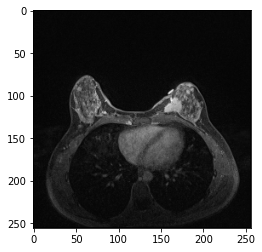

In [87]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print(labels.numpy()[0])
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(image.squeeze(), cmap="gray")

In [94]:
def create_image_model():
    tensor_shape = (IMG_SIZE, IMG_SIZE, 1)

    img_input = Input(shape=(tensor_shape))

    x = Conv2D(32, (3,3), activation="relu")(img_input)
    #x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3,3), activation="relu")(x)
    #x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3,3), activation="relu")(x)
    #x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3,3), activation="relu")(x)
    #x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x =GlobalAveragePooling2D()(x)
    x = Dense(units=128, activation="relu")(x)

    predictions = Dense(1, activation = "sigmoid")(x)

    model_image = Model(inputs = img_input, outputs = predictions)
    
    initial_learning_rate = 0.0001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

    model_image.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.01),
                  loss='binary_crossentropy',
                  metrics= METRICS)
    return model_image


In [95]:
model_image = create_image_model()

In [120]:
model_image.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 252, 252, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 250, 250, 256)     1477

In [96]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2D_image_Neoadjuvant.h5", save_best_only=True
)

#early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
early_stopping_cb  = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience = 10 ,restore_best_weights = True)

## Run the Model

In [97]:
history_image = model_image.fit(train_dataset,   
                    class_weight =class_weights,
                    validation_data = validation_dataset,
                    callbacks=[checkpoint_cb, early_stopping_cb],
                    batch_size = BATCH_SIZE,
                    verbose = 2,
                    epochs=50)

Epoch 1/50
33/33 - 26s - loss: 1.8589 - tp: 42.0000 - fp: 42.0000 - tn: 51.0000 - fn: 50.0000 - accuracy: 0.5027 - precision: 0.5000 - recall: 0.4565 - auc: 0.4844 - prc: 0.4898 - val_loss: 10.9617 - val_tp: 30.0000 - val_fp: 26.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5357 - val_precision: 0.5357 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5357 - 26s/epoch - 795ms/step
Epoch 2/50
33/33 - 13s - loss: 1.5867 - tp: 25.0000 - fp: 32.0000 - tn: 35.0000 - fn: 37.0000 - accuracy: 0.4651 - precision: 0.4386 - recall: 0.4032 - auc: 0.4611 - prc: 0.4699 - val_loss: 2.3783 - val_tp: 30.0000 - val_fp: 26.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5357 - val_precision: 0.5357 - val_recall: 1.0000 - val_auc: 0.4949 - val_prc: 0.5238 - 13s/epoch - 392ms/step
Epoch 3/50
33/33 - 13s - loss: 1.4311 - tp: 30.0000 - fp: 30.0000 - tn: 37.0000 - fn: 32.0000 - accuracy: 0.5194 - precision: 0.5000 - recall: 0.4839 - auc: 0.5468 - prc: 0.4914 - val_loss: 0

# Method two
## Transfer learning

In [ ]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3))
feature_extractor_layer.trainable = False

In [ ]:
def mobilenet_preprocessing(images, labels):
    images = tf.expand_dims(images, axis=3)
    images = tf.image.resize(images,[224,224])
    images = tf.tile(images, [1,1,1,3])
    images = tf.keras.applications.mobilenet_v2.preprocess_input (images)
    return (images, labels)

train_dataset = (
    train_loader
    .batch(BATCH_SIZE)
    .map(mobilenet_preprocessing)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    test_loader
    .batch(BATCH_SIZE)
    .map(mobilenet_preprocessing)
    .prefetch(tf.data.AUTOTUNE)
)

1.0
Dimension of the MRI scan is: (224, 224, 3)


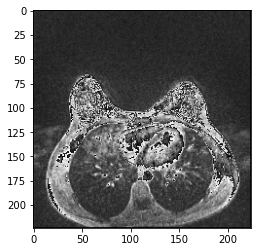

In [ ]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print(labels.numpy()[0])
print("Dimension of the MRI scan is:", image.shape)
plt.imshow((image * 255).astype(np.uint8))

In [ ]:
myModel = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top= False,
    weights="imagenet",
    classes=2,
    pooling=None,
    classifier_activation="sigmoid")

nn_inputs = myModel.input

for layer in myModel.layers:
        layer.trainable = False


myModelOut = myModel.output
myModelOut = GlobalAveragePooling2D()(myModelOut)
myModelOut = Dense(1, activation="sigmoid")(myModelOut)

model_image = Model(inputs=nn_inputs, outputs=myModelOut)

model_image.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [ ]:
model_image.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = "binary_crossentropy",
    metrics=METRICS)

In [ ]:
history_image = model_image.fit(train_dataset,
                                   validation_data=validation_dataset,
                                   batch_size = BATCH_SIZE,
                                   class_weight = class_weights,
                                   epochs=20
                                  )

Epoch 1/20
129/129 [==============================] - 18s 109ms/step - loss: 4.4399 - tp: 33.0000 - fp: 32.0000 - tn: 61.0000 - fn: 60.0000 - accuracy: 0.5054 - precision: 0.5077 - recall: 0.3548 - auc: 0.5391 - prc: 0.5360 - val_loss: 1.7452 - val_tp: 16.0000 - val_fp: 15.0000 - val_tn: 11.0000 - val_fn: 14.0000 - val_accuracy: 0.4821 - val_precision: 0.5161 - val_recall: 0.5333 - val_auc: 0.4878 - val_prc: 0.5083
Epoch 2/20
129/129 [==============================] - 12s 91ms/step - loss: 1.9538 - tp: 41.0000 - fp: 19.0000 - tn: 48.0000 - fn: 21.0000 - accuracy: 0.6899 - precision: 0.6833 - recall: 0.6613 - auc: 0.7371 - prc: 0.7259 - val_loss: 2.0491 - val_tp: 24.0000 - val_fp: 19.0000 - val_tn: 7.0000 - val_fn: 6.0000 - val_accuracy: 0.5536 - val_precision: 0.5581 - val_recall: 0.8000 - val_auc: 0.4994 - val_prc: 0.5265
Epoch 3/20
129/129 [==============================] - 12s 92ms/step - loss: 1.5443 - tp: 48.0000 - fp: 17.0000 - tn: 50.0000 - fn: 14.0000 - accuracy: 0.7597 - preci

# Clinical Model
### As determined by experimentation (see document 'Neoadjuvant Treatment Clinical Data Analysis') feature selected data used and a hyperparameter tuned deep neural network 

## Train and Validation data

In [29]:
clinical_train = train_df[['Response to treatment', 'Date of Birth (Days)', 'Staging(Tumor Size)', 'Staging(Nodes)',
       'PR','Tumor Grade Tubule', 'Tumor Grade Mitotic','Tumor Grade Nuclear', 'Mol Subtype_Luminal A',
       'Lymphadenopathy or Suspicious Nodes']]

clinical_test = test_df[['Response to treatment', 'Date of Birth (Days)', 'Staging(Tumor Size)', 'Staging(Nodes)',
       'PR','Tumor Grade Tubule', 'Tumor Grade Mitotic','Tumor Grade Nuclear', 'Mol Subtype_Luminal A',
       'Lymphadenopathy or Suspicious Nodes']]


In [30]:
clinical_train.head()

,Response to treatment,Date of Birth (Days),Staging(Tumor Size),Staging(Nodes),PR,Tumor Grade Tubule,Tumor Grade Mitotic,Tumor Grade Nuclear,Mol Subtype_Luminal A,Lymphadenopathy or Suspicious Nodes
155,1,14500,2,0,1,3,1,2,1,0
85,1,13318,2,1,0,3,2,3,0,1
150,1,19256,3,1,0,3,3,3,0,1
26,1,23726,2,1,0,3,3,3,0,1
158,0,18439,1,1,1,2,1,2,1,1


In [31]:
print(len(clinical_train))
print(len(clinical_test))

129
56


In [32]:
def test_train_dataset(train_df, test_df, label):

    print(train_df.columns)
    
    # Form np arrays of labels and features.
    y_train = np.array(train_df.pop(label))
    y_test = np.array(test_df.pop(label))

    X_train = np.array(train_df)
    X_test = np.array(test_df)
    
    return X_train, X_test, y_train, y_test

In [33]:
X_train_clinical, X_test_clinical, y_train_clinical, y_test_clinical = test_train_dataset(clinical_train, clinical_test, 'Response to treatment')

Index(['Response to treatment', 'Date of Birth (Days)', 'Staging(Tumor Size)',
       'Staging(Nodes)', 'PR', 'Tumor Grade Tubule', 'Tumor Grade Mitotic',
       'Tumor Grade Nuclear', 'Mol Subtype_Luminal A',
       'Lymphadenopathy or Suspicious Nodes'],
      dtype='object')


In [34]:
scaler = preprocessing.StandardScaler()

X_train_clinical = scaler.fit_transform(X_train_clinical)
X_test_clinical = scaler.transform(X_test_clinical)

## Class Weights

In [35]:
org_size = collections.Counter(y_train_clinical) 

n_classes= 2 
n_sample0= int(org_size.get(0))
n_sample1= int(org_size.get(1))
n_samples= n_sample0 + n_sample1
    

#Weights for class 0 (no response):
w0=  n_samples/(n_classes*n_sample0) 

#Weights for class 1 (complete or partial response):
w1= n_samples/(n_classes*n_sample1)

class_weights = {0:w0*2, 1: w1*2}
print(org_size)
print(class_weights)

Counter({0: 67, 1: 62})
{0: 1.9253731343283582, 1: 2.0806451612903225}



## Simple Neural Network (Prevents overfitting)

In [36]:
input_shape = X_train_clinical.shape[1]
print(input_shape)

9


In [57]:
def create_clinical_model():
    img_input = Input(shape=(input_shape, ))

    x = Dense(64, activation = "relu")(img_input)
    x = Dense(128, activation = "relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation = "relu")(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation = "sigmoid")(x)

    model_clinical = Model(inputs = img_input, outputs = predictions)
    
    model_clinical.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.01),
              loss='binary_crossentropy',
              metrics= METRICS)
    
    return model_clinical

In [58]:
model_clinical = create_clinical_model()

In [59]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2D_clinical_Neoadjuvant.h5", save_best_only=True
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                           mode='max', 
                                           patience=10, 
                                           restore_best_weights =True)

In [60]:
history_clinical = model_clinical.fit(X_train_clinical, 
                                      y_train_clinical,
                                      batch_size= BATCH_SIZE,
                                      validation_data = (X_test_clinical, y_test_clinical), 
                                      class_weight =class_weights,
                                      callbacks=[checkpoint_cb, early_stop],
                                      verbose = 1,
                                      epochs=80)

Epoch 1/80
33/33 [==============================] - 6s 85ms/step - loss: 1.5403 - tp: 65.0000 - fp: 46.0000 - tn: 47.0000 - fn: 27.0000 - accuracy: 0.6054 - precision: 0.5856 - recall: 0.7065 - auc: 0.6338 - prc: 0.6079 - val_loss: 0.6230 - val_tp: 16.0000 - val_fp: 5.0000 - val_tn: 21.0000 - val_fn: 14.0000 - val_accuracy: 0.6607 - val_precision: 0.7619 - val_recall: 0.5333 - val_auc: 0.7340 - val_prc: 0.7799
Epoch 2/80
33/33 [==============================] - 2s 47ms/step - loss: 1.2397 - tp: 41.0000 - fp: 16.0000 - tn: 51.0000 - fn: 21.0000 - accuracy: 0.7132 - precision: 0.7193 - recall: 0.6613 - auc: 0.7553 - prc: 0.6706 - val_loss: 0.5735 - val_tp: 20.0000 - val_fp: 9.0000 - val_tn: 17.0000 - val_fn: 10.0000 - val_accuracy: 0.6607 - val_precision: 0.6897 - val_recall: 0.6667 - val_auc: 0.7647 - val_prc: 0.7906
Epoch 3/80
33/33 [==============================] - 1s 35ms/step - loss: 1.0739 - tp: 51.0000 - fp: 25.0000 - tn: 42.0000 - fn: 11.0000 - accuracy: 0.7209 - precision: 0.67

Epoch 21/80
33/33 [==============================] - 1s 20ms/step - loss: 0.4820 - tp: 56.0000 - fp: 15.0000 - tn: 52.0000 - fn: 6.0000 - accuracy: 0.8372 - precision: 0.7887 - recall: 0.9032 - auc: 0.9627 - prc: 0.9628 - val_loss: 1.3921 - val_tp: 24.0000 - val_fp: 6.0000 - val_tn: 20.0000 - val_fn: 6.0000 - val_accuracy: 0.7857 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.7923 - val_prc: 0.7446
Epoch 22/80
33/33 [==============================] - 1s 38ms/step - loss: 0.4774 - tp: 59.0000 - fp: 16.0000 - tn: 51.0000 - fn: 3.0000 - accuracy: 0.8527 - precision: 0.7867 - recall: 0.9516 - auc: 0.9557 - prc: 0.9539 - val_loss: 1.5880 - val_tp: 20.0000 - val_fp: 5.0000 - val_tn: 21.0000 - val_fn: 10.0000 - val_accuracy: 0.7321 - val_precision: 0.8000 - val_recall: 0.6667 - val_auc: 0.7891 - val_prc: 0.7464
Epoch 23/80
33/33 [==============================] - 1s 37ms/step - loss: 0.5465 - tp: 57.0000 - fp: 13.0000 - tn: 54.0000 - fn: 5.0000 - accuracy: 0.8605 - precision: 0.814

# Model Evaluation
### To avoid re-runing models model weights have been saved as h5 files in the folder Neoadjuvant 2D Models and Weights

In [ ]:
model_image = create_clinical_model()
model_image.load_weights("2d_clinical_neoadjuvant.h5")

In [ ]:
model_clinical = create_image_model()
model_clinical.load_weights("2d_image_neoadjuvant.h5")

In [104]:
# google collab version
!mkdir -p saved_model
model_image.save('saved_model/2D_image_neoadjuvant_model') 
model_clinical.save('saved_model/2D_clinical_neoadjuvant_model')

#model_image = tf.keras.models.load_model('saved_model/2D_image_neoadjuvant')
#model_clinical = tf.keras.models.load_model('saved_model/2D_clinical_neoadjuvant')

INFO:tensorflow:Assets written to: saved_model/2D_image_neoadjuvant_model\assets


INFO:tensorflow:Assets written to: saved_model/2D_image_neoadjuvant_model\assets


INFO:tensorflow:Assets written to: saved_model/2D_clinical_neoadjuvant_model\assets


INFO:tensorflow:Assets written to: saved_model/2D_clinical_neoadjuvant_model\assets


In [69]:
def plot_metrics(history, list_of_metrics):
    
    rows = int(np.ceil(len(list_of_metrics)/2))
    columns = 2
    
    fig, ax = plt.subplots(rows, columns, figsize=(20, 10))
    ax = ax.ravel()

    for i, metric in enumerate(list_of_metrics):
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

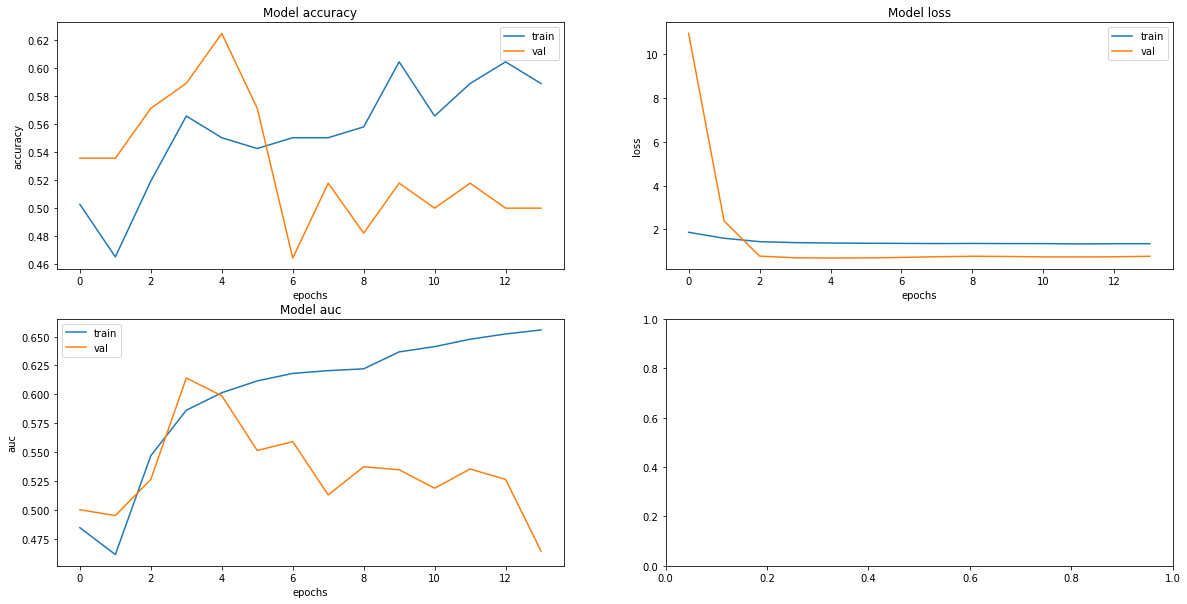

In [98]:
plot_metrics(history_image, ["accuracy", "loss", "auc"])

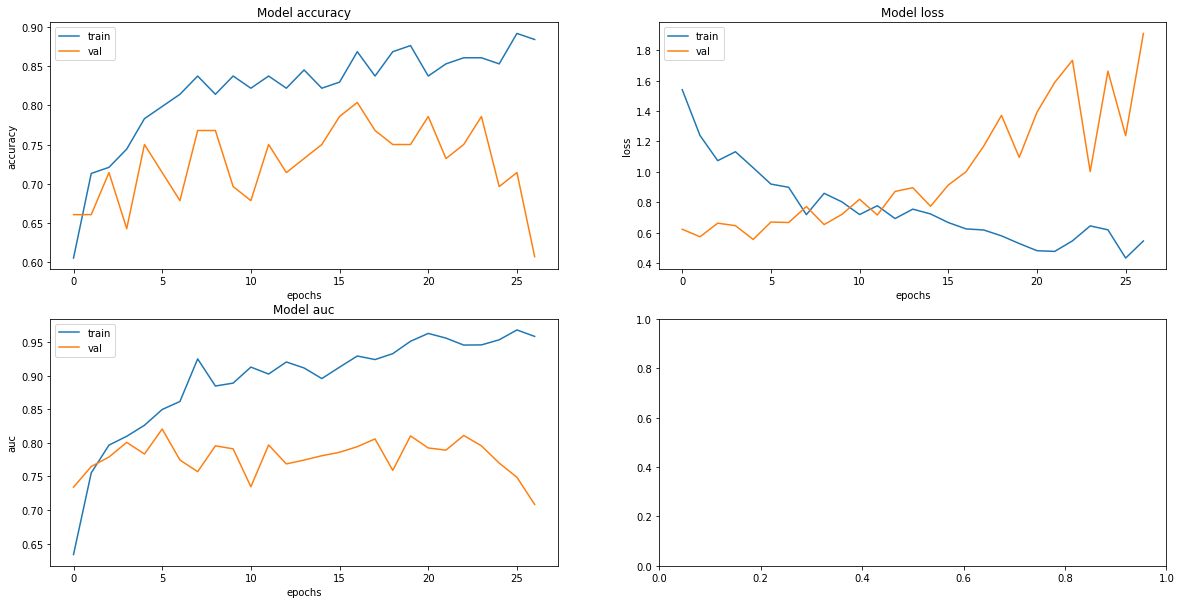

In [61]:
plot_metrics(history_clinical, ["accuracy", "loss", "auc"])

In [44]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

14/14 [==============================] - 2s 126ms/step


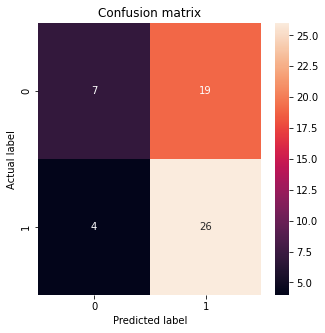

In [99]:
test_predictions_baseline = model_image.predict(validation_dataset, batch_size=BATCH_SIZE)
plot_cm(y_test_image, test_predictions_baseline)

14/14 [==============================] - 0s 3ms/step


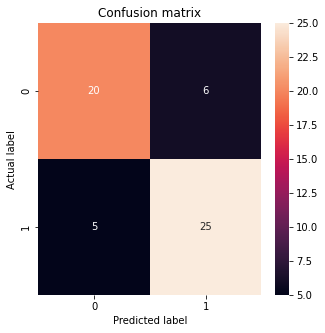

In [62]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
test_predictions_baseline = model_clinical.predict(X_test_clinical, batch_size=BATCH_SIZE)
plot_cm(y_test_clinical, test_predictions_baseline)

In [47]:
def plot_roc(name, labels, predictions, **kwargs):
      
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    ax = plt.gca()
    ax.set_aspect('equal')

14/14 [==============================] - 1s 106ms/step


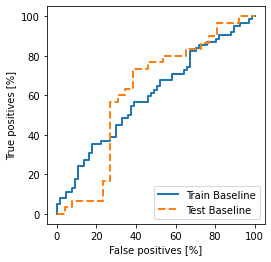

In [100]:
train_predictions_baseline = model_image.predict(train_dataset, batch_size=BATCH_SIZE)
test_predictions_baseline = model_image.predict(validation_dataset, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", y_train_image, train_predictions_baseline)
plot_roc("Test Baseline", y_test_image, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')

14/14 [==============================] - 0s 4ms/step


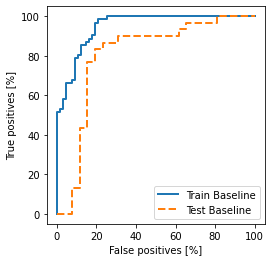

In [63]:
train_predictions_baseline = model_clinical.predict(X_train_clinical, batch_size=BATCH_SIZE)
test_predictions_baseline = model_clinical.predict(X_test_clinical, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", y_train_clinical, train_predictions_baseline)
plot_roc("Test Baseline", y_test_clinical, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')

In [101]:
baseline_results = model_image.evaluate(validation_dataset,batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_image.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  0.6930351853370667
tp :  26.0
fp :  19.0
tn :  7.0
fn :  4.0
accuracy :  0.5892857313156128
precision :  0.5777778029441833
recall :  0.8666666746139526
auc :  0.6141025424003601
prc :  0.5669113993644714


In [64]:
baseline_results = model_clinical.evaluate(X_test_clinical, y_test_clinical,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_clinical.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  1.0008068084716797
tp :  25.0
fp :  6.0
tn :  20.0
fn :  5.0
accuracy :  0.8035714030265808
precision :  0.8064516186714172
recall :  0.8333333134651184
auc :  0.7942308187484741
prc :  0.7152458429336548


# Fusion of Predictions
### We can see here even though our image model is quite poor due to high sensitvity this has actually improved our predictions  to 82%  accuracy and F1 of 84%

In [102]:
prediction = model_clinical.predict(np.expand_dims(X_test_clinical[0], axis=0))[0]
print("Actual :", y_test_clinical[0])
scores = [1 - prediction[0], prediction[0]]

class_names = ["no response to treatment", "response to treatment"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that this patient will have %s"
        % ((100 * score), name)
    )

1/1 [==============================] - 0s 81ms/step
Actual : 1
This model is 27.56 percent confident that this patient will have no recurrence
This model is 72.44 percent confident that this patient will have recurrence


1/1 [==============================] - 0s 57ms/step
this image is 39.81 confident of no recurrence
this image is 60.19 confident of recurrence


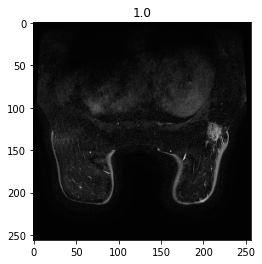

In [103]:
class_names = ["no response to treatment", "response to treatment"]
for image , label in validation_dataset.take(1):
    image = image.numpy()
    label = label.numpy()
    image = image[0]
    plt.imshow(image.squeeze(), cmap = "gray")
    #for mobilenet
    #plt.imshow((image[0]*255).astype(np.uint8))
    plt.title(str(label[0]))
    
prediction = model_image.predict(validation_dataset.take(1))[0]
scores = [1-prediction, prediction]

for score, name in zip(scores, class_names):
    print("this image is %.2f confident of %s" % ((100*score), name))

1/1 [==============================] - 0s 53ms/step


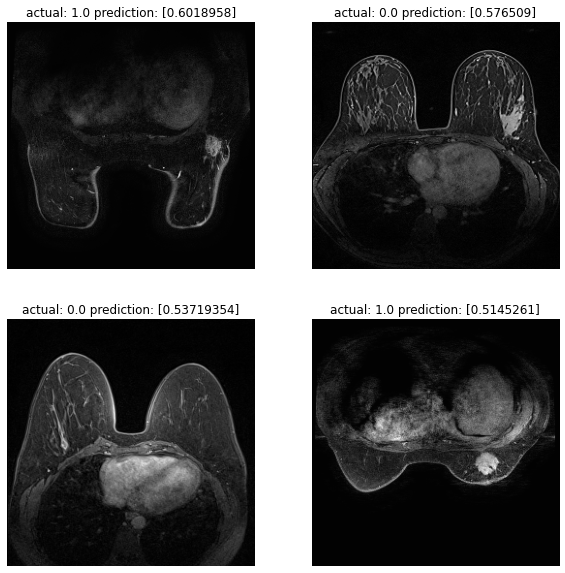

In [116]:
class_names = ["no response to treatment", "response to treatment"]
fig, ax = plt.subplots(2,2, figsize = [10,10])
i = 0
while i < 4:
    for image , label in validation_dataset.take(1):
        image = image.numpy()
        label = label.numpy()
        image = image[i]
        ax.flat[i].imshow(image.squeeze(), cmap = "gray")
        ax.flat[i].axis('off')
        
        prediction = model_image.predict(validation_dataset.take(1))[i]
        ax.flat[i].set_title("actual: " + str(label[i]) + ", prediction: " + str(prediction))
        
        i+=1

## Combine both image and and clinical predictions and compare results 
**Experimentaion was done to determine alpha and beta the percentage of which results are used in the average of prediciton, here we have settles with 40% image prediciton and 60% clinical prediction**

In [117]:
true_positives = []
true_negatives = []
false_positives = []
false_negatives = []

fusion_values = []

def normal_process(image):
    image = tf.cast(image, tf.float32) /255.
    
    return image

def mobilenet_process(images):
    images = tf.expand_dims(images, axis=2)
    images = tf.image.resize(images,[224,224])
    images = tf.tile(images, [1,1,3])
    images = tf.keras.applications.mobilenet_v2.preprocess_input (images)
    return images

for index in range(0, len(y_test_clinical)):
    #mobilenet processing needed
    #prediction_image = model_image.predict(np.expand_dims(mobilenet_process(X_test_image[index]), axis=0))[0]
    prediction_image = model_image.predict(np.expand_dims(normal_process(X_test_image[index]), axis = 0))[0]
    prediction_clinical = model_clinical.predict(np.expand_dims(X_test_clinical[index], axis = 0))[0]

    print("Actual :", y_test_clinical[index], y_test_image[index])
    print(prediction_image, prediction_clinical)

    fusion = (0.4*prediction_image)+(0.6*prediction_clinical)
    fusion_values.append(fusion[0])
    print(fusion)

    if np.around(fusion) == 1 and y_test_clinical[index] == 1:
        true_positives.append(fusion)
    elif np.around(fusion) == 1 and y_test_clinical[index] == 0:
        false_positives.append(fusion)
    elif np.around(fusion) == 0 and y_test_clinical[index] == 0:
        true_negatives.append(fusion)
    elif np.around(fusion) == 0 and y_test_clinical[index] == 1:
        false_negatives.append(fusion)
    else:
        print("error")   



1/1 [==============================] - 0s 15ms/step
Actual : 1 1.0
[0.6018958] [0.72439134]
[0.67539316]
1/1 [==============================] - 0s 15ms/step
Actual : 0 0.0
[0.576509] [0.00067992]
[0.23101155]
1/1 [==============================] - 0s 17ms/step
Actual : 0 0.0
[0.5371936] [0.01361414]
[0.22304593]
1/1 [==============================] - 0s 16ms/step
Actual : 1 1.0
[0.5145261] [0.00051277]
[0.20611812]
1/1 [==============================] - 0s 14ms/step
Actual : 0 0.0
[0.8280196] [0.00024151]
[0.33135274]
1/1 [==============================] - 0s 15ms/step
Actual : 1 1.0
[0.5023316] [0.07204029]
[0.24415682]
1/1 [==============================] - 0s 15ms/step
Actual : 1 1.0
[0.55725497] [0.5442382]
[0.5494449]
1/1 [==============================] - 0s 17ms/step
Actual : 1 1.0
[0.6446351] [0.8968365]
[0.79595596]
1/1 [==============================] - 0s 17ms/step
Actual : 0 0.0
[0.530395] [0.9889102]
[0.8055041]
1/1 [==============================] - 0s 17ms/step
Actual : 

1/1 [==============================] - 0s 15ms/step
Actual : 1 1.0
[0.5328563] [0.61032754]
[0.579339]
1/1 [==============================] - 0s 15ms/step
Actual : 0 0.0
[0.4700656] [2.3631353e-07]
[0.18802638]
1/1 [==============================] - 0s 15ms/step
Actual : 0 0.0
[0.76313585] [0.000318]
[0.30544513]
1/1 [==============================] - 0s 15ms/step
Actual : 0 0.0
[0.5293138] [0.1169994]
[0.28192517]


# Calculations 

* Accuracy = correct guesses/ total number of values
* Precision = TruePositives / (TruePositives + FalsePositives)
* Recall = TruePositives / (TruePositives + FalseNegatives)
* F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

In [118]:
print(len(true_positives))
print(len(true_negatives))
print(len(false_positives))
print(len(false_negatives))

26
20
6
4


In [119]:
def metrics(tp, tn, fp, fn):
    accuracy = (tp+tn)/(tp +tn +fp +fn)
    precision = tp / (tp +fp)
    recall = tp / (tp+fn)
    f1 = 2* (precision * recall)/ (precision + recall)
    print("accuracy: ", accuracy)
    print("precision: ", precision)
    print("recall: ", recall)
    print("f1: ", f1)

metrics(len(true_positives), len(true_negatives), len(false_positives), len(false_negatives))

accuracy:  0.8214285714285714
precision:  0.8125
recall:  0.8666666666666667
f1:  0.8387096774193549
